In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import Counter
import numpy as np

%matplotlib inline

In [116]:
'''

Take in logging_file_init + logging_file_tree + clusered_db + optional cluster_id
Generate some statistics about the clusters (distribution of cluster sizes, avg containment in this cluster)
Get one cluster (by ID or at random)

For a particular cluster...
Get the .fasta files from genbank associated with all seqs

For each pair of removed/retained seqs...
Optional: align to retained seq, get metrics 
    (how many base to N positions in retained, count of base-to-N positions in removed, of non-base-to-N positions...what percentage are matched v. mismatched)

Remove stretches of Ns from .fasta files
Simulate reads
Align with minimap2 to retained seq
Align with minimap2 to clustered DB
Return (containment of pair / percentage of reads unmapped to seq / percentage of reads unmapped to DB)

'''

'\n\nTake in logging_file_init + logging_file_tree + clusered_db + optional cluster_id\nGenerate some statistics about the clusters (distribution of cluster sizes, avg containment in this cluster)\nGet one cluster (by ID or at random)\n\nFor a particular cluster...\nGet the .fasta files from genbank associated with all seqs\n\nFor each pair of removed/retained seqs...\nOptional: align to retained seq, get metrics \n    (how many base to N positions in retained, count of base-to-N positions in removed, of non-base-to-N positions...what percentage are matched v. mismatched)\n\nRemove stretches of Ns from .fasta files\nSimulate reads\nAlign with minimap2 to retained seq\nAlign with minimap2 to clustered DB\nReturn (containment of pair / percentage of reads unmapped to seq / percentage of reads unmapped to DB)\n\n'

In [117]:
# required parameters to specify inputs/outputs
logging_file_init = './data/logging_contained_in_chunk.tsv'
logging_file_tree = './data/logging_contained_in_tree.tsv'
clustered_db = './data/nt_compressed_compressed_chkv_dump.fa'
cluster_id = 'HM045820.1' #'OP485450.1'

output_dir = './output1/' # this will contain all downloaded seqs and resulting analyses

In [118]:
# read in the logging files
log_init_df = pd.read_csv(logging_file_init, sep='\t')
log_tree_df = pd.read_csv(logging_file_tree, sep='\t')

In [119]:
# configure the logging files so that we can generate statistics on them 

def split_double_log_values(log_df):
    '''
    in cases where _retained_ is actually two (or more) entries...
    just take the last entry and the associated containment value
    '''
    log_df['retained'] = [i.split(',')[-1] for i in list(log_df['retained'])]
    print(type(log_df['containment'][0]))
    try:
        log_df['containment'] = [i.split(',')[-1] for i in list(log_df['containment'])]
    except:
        print('no double log values found')
    log_df['containment'] = pd.to_numeric(log_df['containment'])
    return(log_df)

log_init_df = split_double_log_values(log_init_df)
log_tree_df = split_double_log_values(log_tree_df)

<class 'str'>
<class 'numpy.float64'>
no double log values found


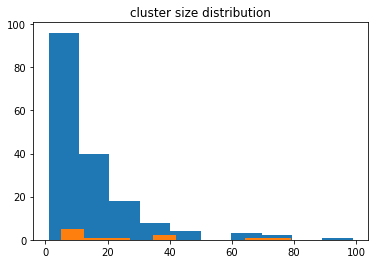

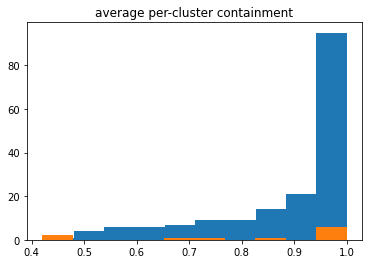

In [120]:
# plot histogram of cluster sizes
plt.hist(log_init_df.groupby('retained')['containment'].count())
plt.hist(log_tree_df.groupby('retained')['containment'].count())
plt.title("cluster size distribution")
plt.show()
# plot histogram of containment values
plt.hist(log_init_df.groupby('retained')['containment'].mean())
plt.hist(log_tree_df.groupby('retained')['containment'].mean())
plt.title("average per-cluster containment")
plt.show()

In [121]:
# combine the two cluster inputs
full_df = pd.concat([log_init_df, log_tree_df])
all_cluster_sizes = full_df.groupby('retained')['containment'].count().sort_values(ascending=False)
all_cluster_sizes.head()

retained
gi|1168909498|gb|KY703956.1|    178
gi|1194463519|gb|KY435486.1|     93
gi|2315911188|gb|ON142089.1|     78
gi|1928144300|gb|MT933051.1|     77
gi|2007118884|gb|MN954552.1|     69
Name: containment, dtype: int64

In [122]:
# select just one cluster to investigate (based on input)
current_cluster_df = full_df[[cluster_id in i for i in list(full_df['retained'])]]

# select just one cluaster (based on size)
#top_cluster = str(all_cluster_sizes.head(1).index).split('|')[-2]
#current_cluster_df = full_df[[top_cluster in i for i in list(full_df['retained'])]]

In [123]:
current_cluster_df['seq_id'] = [i.split('|')[-2] for i in current_cluster_df['discarded']]
current_cluster_df

<ipython-input-123-150e5a9fee66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_cluster_df['seq_id'] = [i.split('|')[-2] for i in current_cluster_df['discarded']]


,discarded,retained,containment,seq_id
2221,gi|296124579|gb|HM045819.1|,gi|296124582|gb|HM045820.1|,0.900000,HM045819.1
2222,gi|296124576|gb|HM045818.1|,gi|296124582|gb|HM045820.1|,0.909091,HM045818.1
2223,gi|296124573|gb|HM045817.1|,gi|296124582|gb|HM045820.1|,0.750000,HM045817.1
2224,gi|296124570|gb|HM045816.1|,gi|296124582|gb|HM045820.1|,0.600000,HM045816.1
2225,gi|296124567|gb|HM045815.1|,gi|296124582|gb|HM045820.1|,0.500000,HM045815.1
2232,gi|296124544|gb|HM045807.1|,gi|296124582|gb|HM045820.1|,0.875000,HM045807.1
2235,gi|296124535|gb|HM045804.1|,gi|296124582|gb|HM045820.1|,0.800000,HM045804.1
2241,gi|296124518|gb|HM045798.1|,gi|296124582|gb|HM045820.1|,0.571429,HM045798.1
2253,gi|296124483|gb|HM045786.1|,gi|296124582|gb|HM045820.1|,0.875000,HM045786.1
2254,gi|296124480|gb|HM045785.1|,gi|296124582|gb|HM045820.1|,0.571429,HM045785.1


In [124]:
# get all sequence names...
discarded_seqs = list(set([i.split('|')[-2] for i in list(current_cluster_df['discarded'])]))
retained_seqs = list(set([i.split('|')[-2] for i in list(current_cluster_df['retained'])]))
all_seq_ids = {'discarded': discarded_seqs, 'retained':retained_seqs}
all_seq_ids_list = discarded_seqs + retained_seqs

In [125]:
''' # install eutils (instructions here: https://www.ncbi.nlm.nih.gov/books/NBK179288/)
! sh -c "$(curl -fsSL https://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect/install-edirect.sh)"
! export PATH=${HOME}/edirect:${PATH} #not sure that this actually registers in the jupyter notebook
'''

' # install eutils (instructions here: https://www.ncbi.nlm.nih.gov/books/NBK179288/)\n! sh -c "$(curl -fsSL https://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect/install-edirect.sh)"\n! export PATH=${HOME}/edirect:${PATH} #not sure that this actually registers in the jupyter notebook\n'

In [126]:
# create an output directory based on initial input
! mkdir {output_dir}

mkdir: ./output1/: File exists


In [127]:
# Get the .fasta files from genbank associated with all seqs
for this_seq in all_seq_ids_list:
    print(this_seq)
    print("working...")
    ! /Users/katrina.kalantar/edirect/esearch -db nucleotide -query {this_seq} | /Users/katrina.kalantar/edirect/efetch -format fasta > {output_dir}{this_seq}.fasta


HM045816.1
working...
HM045807.1
working...
HM045818.1
working...
HM045804.1
working...
HM045817.1
working...
HM045798.1
working...
HM045815.1
working...
HM045786.1
working...
AY726732.1
working...
HM045819.1
working...
HM045785.1
working...
HM045820.1
working...


In [128]:
# OPTIONAL -- do pairwise sequence alignment and investigate the output

In [ ]:
# create the simulated files needed for alignment experiment!!

for this_seq in all_seq_ids_list:
    records = list(SeqIO.parse(output_dir + this_seq + '.fasta', "fasta"))
    this_sequence = str(records[0].seq)    
    new_record = SeqRecord(Seq(this_sequence.replace('NNNNN', '')), 
                           id=records[0].id, 
                           name=records[0].name, description=records[0].description)
    
    # write the new, no-Ns fasta sequence to a new file
    noN_filename = output_dir + this_seq + 'noN.fasta'
    SeqIO.write(new_record, noN_filename, "fasta")
    
    ! iss generate --genomes {noN_filename} --model miseq --output {output_dir + this_seq}.miseq_reads --n_reads 10000
    

INFO:iss.app:Starting iss generate
INFO:iss.app:Using kde ErrorModel
INFO:iss.util:Stitching input files together
INFO:iss.app:Using lognormal abundance distribution
INFO:iss.app:Using 2 cpus for read generation
INFO:iss.app:Generating 10000 reads
INFO:iss.app:Generating reads for record: HM045816.1
INFO:iss.util:Stitching input files together
INFO:iss.util:Stitching input files together
INFO:iss.util:Cleaning up
INFO:iss.app:Read generation complete


In [ ]:
# run the alignment experiment for each discarded sequence and gather metrics

ref_seq = output_dir + all_seq_ids['retained'][0] + '.fasta'

results_dict = {}

for this_seq in all_seq_ids['discarded']:
    print(this_seq)
    input_r1 = output_dir + this_seq + '.miseq_reads_R1.fastq'
    input_r2 = output_dir + this_seq + '.miseq_reads_R2.fastq'
    
    results_dict[this_seq] = {}
    
    # align reads only to the retained seq
    ! minimap2 -ax sr {ref_seq} {input_r1} {input_r2} > {output_dir + this_seq}.alnseq.sam
    ! samtools stats {output_dir + this_seq}.alnseq.sam > {output_dir + this_seq}.alnseq.stats.txt
    unmapped_reads_string = ! grep "reads unmapped:" {output_dir + this_seq}.alnseq.stats.txt
    unmapped_reads_count = int(unmapped_reads_string[0].split(':')[-1].strip())
    results_dict[this_seq]['seqmap'] = unmapped_reads_count
    print(unmapped_reads_count)
    
    # align reads to the full clustered DB
    ! minimap2 -ax sr {clustered_db} {input_r1} {input_r2} > {output_dir + this_seq}.alndb.sam
    ! samtools stats {output_dir + this_seq}.alndb.sam > {output_dir + this_seq}.alndb.stats.txt
    unmapped_reads_string = ! grep "reads unmapped:" {output_dir + this_seq}.alndb.stats.txt
    unmapped_reads_count = int(unmapped_reads_string[0].split(':')[-1].strip())
    results_dict[this_seq]['dbmap'] = unmapped_reads_count
    print(unmapped_reads_count)
    
    containment = current_cluster_df[current_cluster_df.seq_id==this_seq]['containment'].iloc[0]
    results_dict[this_seq]['containment'] = containment
   
    print(results_dict[this_seq])
    print("\n\n")


In [ ]:
mapping_results_df = pd.DataFrame.from_dict(results_dict, orient='index')
mapping_results_df

In [ ]:
ref_seq = output_dir + all_seq_ids['retained'][0] + '.fasta'
all_results = {}

for this_seq in all_seq_ids['discarded']:
    ! cat {ref_seq} {output_dir + this_seq}.fasta > {output_dir + this_seq}.muscle.fasta
    ! muscle -in {output_dir + this_seq}.muscle.fasta -out {output_dir + this_seq}.aln 
    
    
    
    records = list(SeqIO.parse( output_dir + this_seq + ".aln", "fasta"))   
    
    
    seq_ref = str(records[0].seq)
    seq_b = str(records[1].seq)
    
    pairs = []
    for i in range(len(seq_ref)):
        pairs.append(seq_ref[i] + '/' + seq_b[i])

    tally = Counter(pairs)

    result={}

    result['ESref'] = tally['-/A'] + tally['-/C'] + tally['-/G'] + tally['-/T']
    result['ESb'] = tally['A/-'] + tally['C/-'] + tally['G/-'] + tally['T/-']
    result['ENref'] = tally['N/-'] 
    result['ENb'] = tally['-/N'] 
    result['Nref'] = tally['N/A'] + tally['N/C'] + tally['N/G'] + tally['N/T']
    result['Nb'] = tally['A/N'] + tally['G/N'] + tally['C/N'] + tally['T/N']
    result['match'] = tally['A/A'] + tally['G/G'] + tally['C/C'] + tally['T/T']
    result['mismatch'] = tally['A/C'] + tally['A/G'] + tally['A/T'] + tally['C/A'] + tally['C/G'] + tally['C/T'] + tally['G/A'] + tally['G/C'] + tally['G/T'] + tally['T/A'] + tally['T/C'] + tally['T/G']
    result['alignment length'] = len(seq_ref)
    result['seq_length'] = len(seq_b.replace('-',''))
    
    result['pid'] = np.round(result['match'] / (result['match'] + result['mismatch'] ), 3)
    print(result)
    
    all_results[this_seq] = result
    
    print("\n\n")
    

In [ ]:
pairwise_results_df = pd.DataFrame.from_dict(all_results, orient='index')
pairwise_results_df

In [ ]:
joint_results_df = pd.concat([mapping_results_df, pairwise_results_df], axis=1)
joint_results_df.sort_values(by='containment', ascending = True, inplace=True)
joint_results_df